In [5]:
%load_ext autoreload
%autoreload 2
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import torch
# add project root dir to sys.path so that all packages can be found by python.
root_dir = os.path.dirname(os.path.realpath("__file__"))
sys.path.append(root_dir)
import data.utils as data_utils
import model.utils as model_utils
from test import predict_song, predict
from model.waveunet_params import waveunet_params
from MS2.train_apply import _create_waveunet
from data.viz import play_audio, plot_specgram
import tempfile
import librosa
import museval

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
args = waveunet_params.get_defaults()
args.instruments = ["accompaniment", "vocals"]
args.sr = 22050
args.channels = 1
model = _create_waveunet(args)
exp4 = "checkpoint_493495"
state = model_utils.load_model(model=model, optimizer=None, path=exp4, cuda=False)


Using valid convolutions with 53929 inputs and 44377 outputs
parameter count:  35073730


In [27]:
def predict_audio(args, audio_path, model):
    mix_audio, mix_sr = data_utils.load(audio_path, sr=None, mono=False)
    mix_channels = mix_audio.shape[0]
    mix_len = mix_audio.shape[1]

    # Adapt mixture channels to required input channels
    if args.channels == 1:
        mix_audio = np.mean(mix_audio, axis=0, keepdims=True)
    else:
        if mix_channels == 1: # Duplicate channels if input is mono but model is stereo
            mix_audio = np.tile(mix_audio, [args.channels, 1])
        else:
            assert(mix_channels == args.channels)
    # resample to model sampling rate
    mix_audio = data_utils.resample(mix_audio, mix_sr, args.sr)
    sources = predict(mix_audio, model)
    return sources

def seperate_audio(url, args, model):
    temp_dir = tempfile.TemporaryDirectory()
    #download audio file in temp dir
    audio_path = pytube.YouTube(url).streams.filter(only_audio=True).first().download(temp_dir.name)
    y, _ = librosa.load(audio_path, sr=args.sr) #load original
    results = predict_audio(args, audio_path, model)
    temp_dir.cleanup()
    original = np.expand_dims(y, 0)
    return original, results

def seperate_local_audio(audio_path, args, model):
    y, _ = librosa.load(audio_path, sr=args.sr) #load original
    results = predict_audio(args, audio_path, model)
    return y, results

def play_and_visualize(audio, args, model, start=30, duration=5, title="Spectogram"):
    start_frame = start*args.sr 
    end_frame = start_frame + duration*args.sr
    original = audio[: ,start_frame:end_frame]
    play_audio(original, args.sr)
    plot_specgram(original, args.sr, title)
    
def plot_residue(mixture_audio, vocals_audio, accompaniment_audio):
    residual = abs(mixture_audio - (vocals_audio + accompaniment_audio))
    residual_t = np.zeros((residual.shape[1]//args.sr))
    for t in range(len(residual_t)-1):
        residual_t[t] = residual[:, args.sr*t: args.sr*t+1].sum()
    plt.plot(residual_t)
    return residual_t

def retrieve_metrics(target_sources, pred_sources, instruments=["vocals", "accompaniment"]):
    SDR, ISR, SIR, SAR, _ = museval.metrics.bss_eval(target_sources, pred_sources)
    song = {}
    for idx, name in enumerate(instruments):
        song[name] = {"SDR" : SDR[idx], "ISR" : ISR[idx], "SIR" : SIR[idx], "SAR" : SAR[idx]}
    return song

def plot_metrics_vs_residual(metrics, residual, instrument="vocals", metric="SDR"):
    num_windows = len(metrics[instrument][metric])
    num_frames = len(residual)//num_windows
    residual_w = np.zeros(num_windows)
    for win in range(num_windows-1):
        residual_w[win] = residual[num_frames*win: num_frames*(win+1)].sum()
        
    fig,ax = plt.subplots()
    ax.plot(metrics[instrument][metric], color="red", marker="o")
    ax.set_ylabel(metric,color="red",fontsize=14)
    ax2=ax.twinx()
    ax2.plot(residual_w,color="blue",marker="o")
    ax2.set_ylabel("Residual",color="blue",fontsize=14)
    plt.show()
    print(f"Correlation coefficients = {np.corrcoef(np.nan_to_num(metrics[instrument][metric]),  residual_w)}")
    

In [7]:
y, _ = librosa.load("sample/vocals.wav", sr=args.sr)
vocals_audio = np.expand_dims(y, 0)
y, _ = librosa.load("sample/accompaniment.wav", sr=args.sr)
accompaniment_audio = np.expand_dims(y, 0)
mixture_audio, local_results = seperate_local_audio("sample/mixture.wav", args, model)

In [10]:
target_sources = np.stack([vocals_audio, accompaniment_audio]).squeeze()
pred_sources = np.stack([local_results["vocals"], local_results["accompaniment"]]).squeeze()
metrics = retrieve_metrics(target_sources, pred_sources)

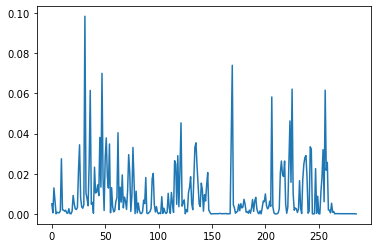

In [28]:
residual = plot_residue(mixture_audio, local_results["vocals"], local_results["accompaniment"])

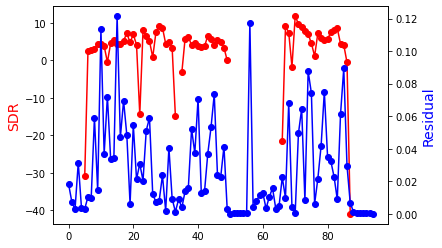

Correlation coefficients = [[1.         0.25466558]
 [0.25466558 1.        ]]


In [29]:
plot_metrics_vs_residual(metrics, residual, "vocals", "SDR")